In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers import Input

from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

ImportError: cannot import name 'kullback_leibler_divergence' from 'keras.losses' (c:\Users\tushar swarnkar\anaconda3\envs\tensorflow_env\lib\site-packages\keras\losses\__init__.py)

In [12]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = 'C:/Users/tushar swarnkar/Tushar anaconda/Project hackathon/PlantVillage'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [13]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
20634,Tomato_healthy/ff354b62-5981-43d1-8cfe-ac58bc2...,14,Tomato_healthy
20635,Tomato_healthy/ff774aec-2504-4d11-8a61-2fd74c6...,14,Tomato_healthy
20636,Tomato_healthy/ff8b36d5-feaf-4d2d-8126-18670a3...,14,Tomato_healthy
20637,Tomato_healthy/ffb39943-eabb-42cf-ad09-b17019e...,14,Tomato_healthy
20638,Tomato_healthy/ffd8aa68-138f-4114-96c7-21eef72...,14,Tomato_healthy


In [14]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/9d197d8a-3f35-401a-8aa4-39f7e69...,14,Tomato_healthy
1,Potato___Early_blight/900514b4-8768-4370-bc53-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/dc5f2f7d-8b86-402e-8...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/e3b5600f-9c88-4060-826f-aa7c972...,14,Tomato_healthy
4,Tomato_Leaf_Mold/2e84cbfc-af2c-4c2b-9273-84275...,8,Tomato_Leaf_Mold


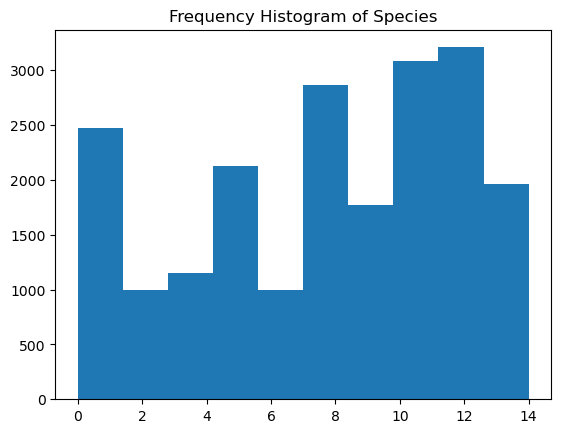

<Figure size 1200x1200 with 0 Axes>

In [15]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

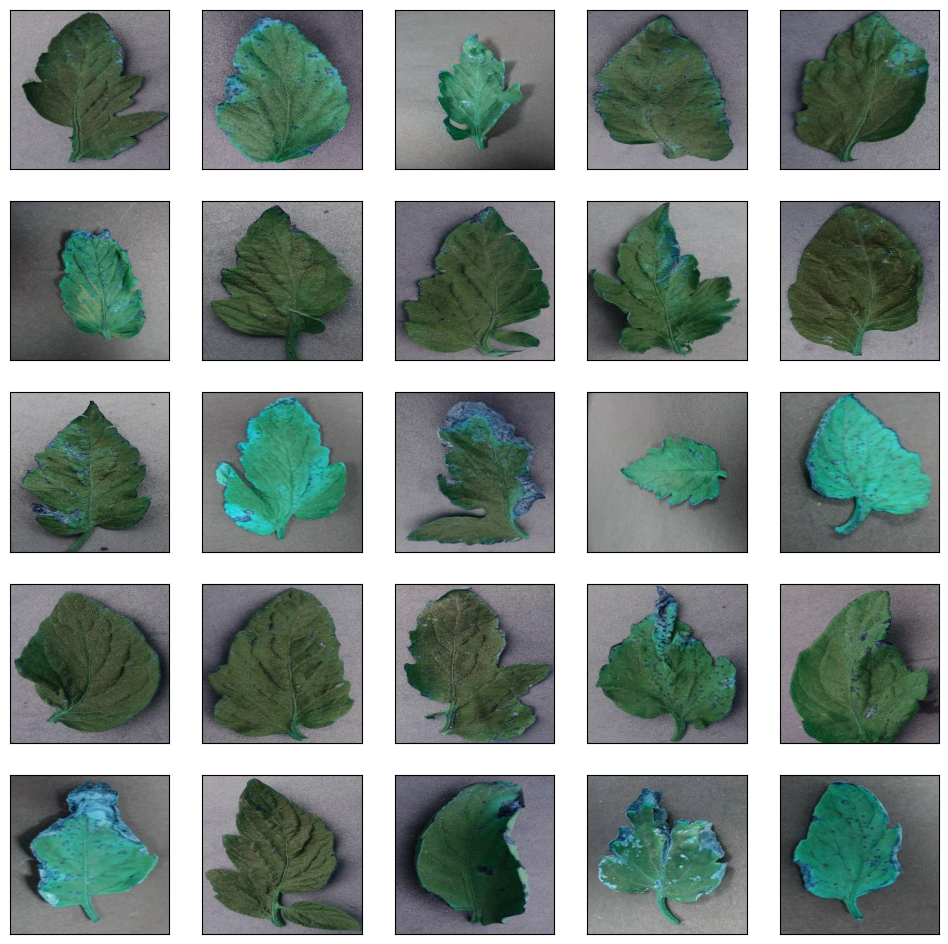

In [16]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [17]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [18]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

3it [00:00, 28.04it/s]

20639it [03:25, 100.39it/s]


Train Shape: (20639, 64, 64, 3)


In [19]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [20]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

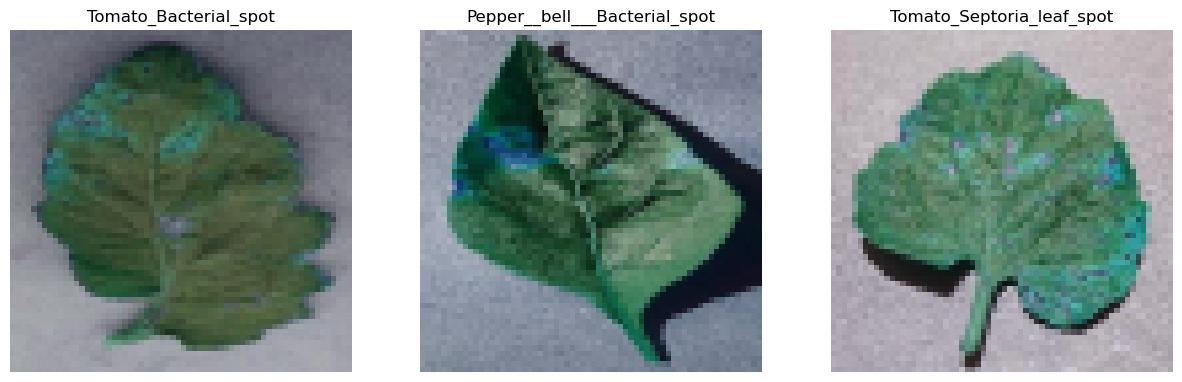

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [25]:
EPOCHS = 5
SIZE=64
N_ch=3

In [26]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [27]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('modelt.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0   

C:\Users\tushar swarnkar\AppData\Local\Temp\ipykernel_17580\3046656700.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/5

Epoch 1: val_loss improved from inf to 4.06702, saving model to modelt.h5
257/257 - 535s - loss: 2.6514 - accuracy: 0.3136 - val_loss: 4.0670 - val_accuracy: 0.2188 - lr: 0.0020 - 535s/epoch - 2s/step
Epoch 2/5

Epoch 2: val_loss improved from 4.06702 to 1.76082, saving model to modelt.h5
257/257 - 574s - loss: 1.1093 - accuracy: 0.6510 - val_loss: 1.7608 - val_accuracy: 0.5901 - lr: 0.0020 - 574s/epoch - 2s/step
Epoch 3/5

Epoch 3: val_loss improved from 1.76082 to 0.80873, saving model to modelt.h5
257/257 - 497s - loss: 0.6640 - accuracy: 0.7860 - val_loss: 0.8087 - val_accuracy: 0.7701 - lr: 0.0020 - 497s/epoch - 2s/step
Epoch 4/5

Epoch 4: val_loss did not improve from 0.80873
257/257 - 597s - loss: 0.4499 - accuracy: 0.8526 - val_loss: 0.9231 - val_accuracy: 0.7764 - lr: 0.0020 - 597s/epoch - 2s/step
Epoch 5/5

Epoch 5: val_loss improved from 0.80873 to 0.57131, saving model to modelt.h5
257/257 - 688s - loss: 0.3426 - accuracy: 0.8898 - val_loss: 0.5713 - val_accuracy

In [28]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

129/129 [==============================] - 53s 406ms/step - loss: 0.5713 - accuracy: 0.8365
Final Loss: 0.5713102221488953, Final Accuracy: 0.836482584476471


129/129 [==============================] - 25s 185ms/step


Text(0.5, 192.58159722222217, 'Predicted')

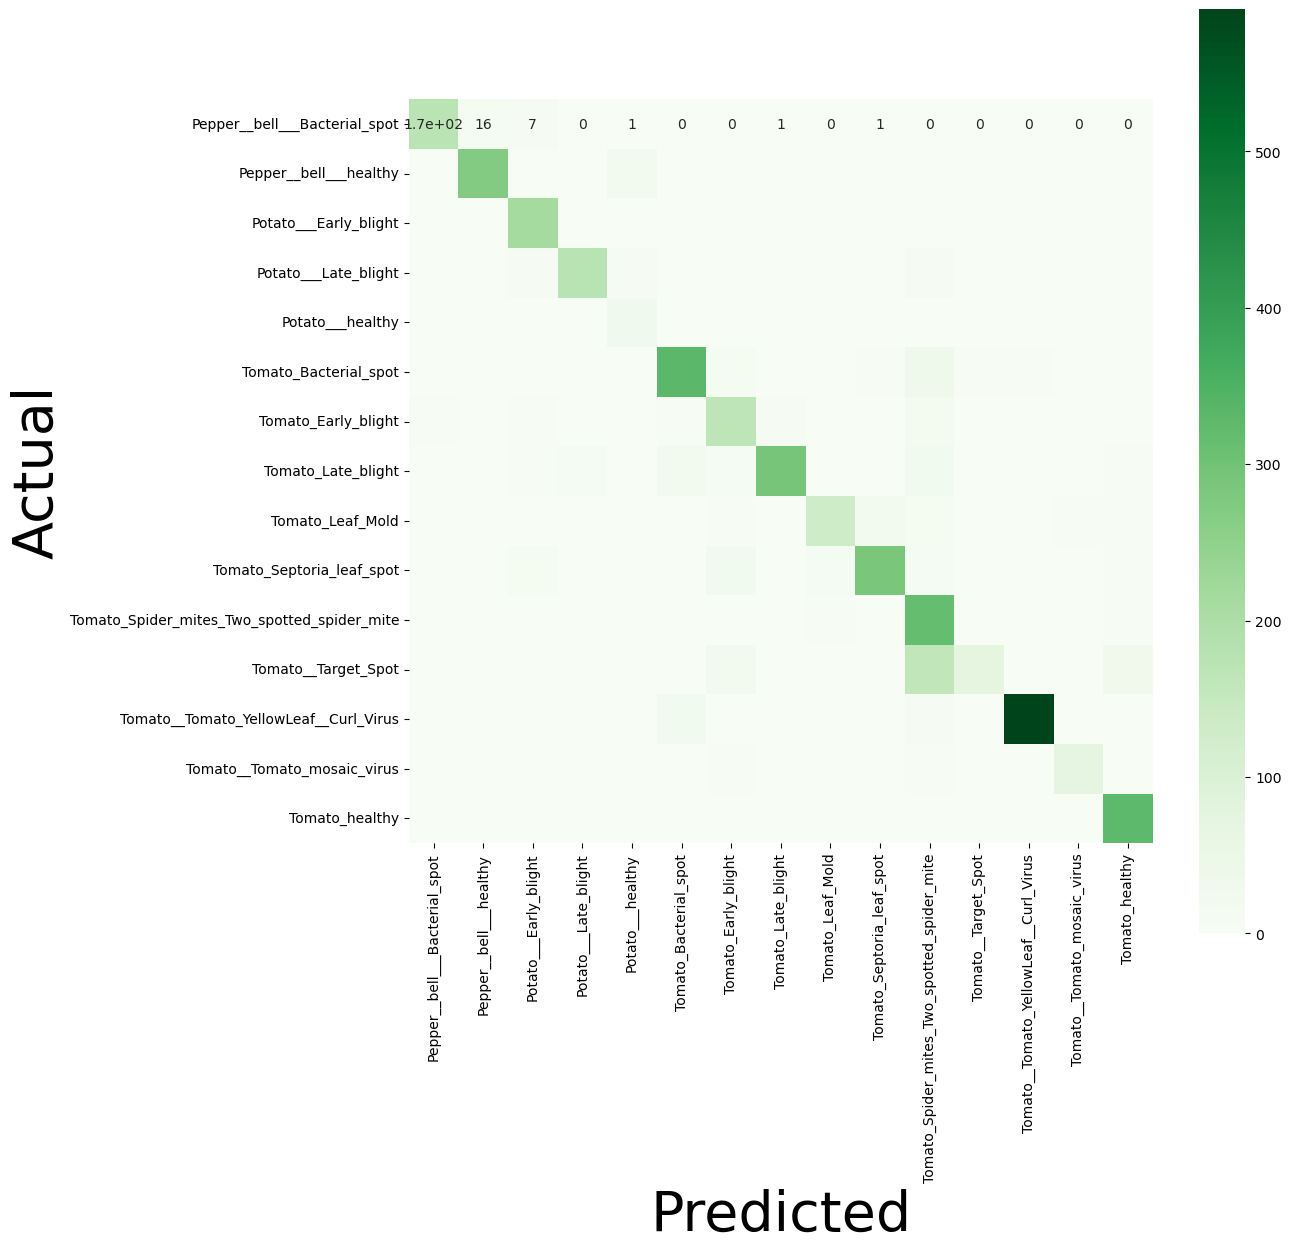

In [56]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

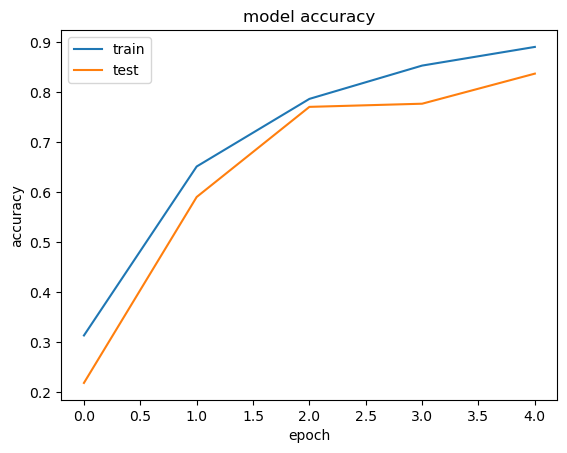

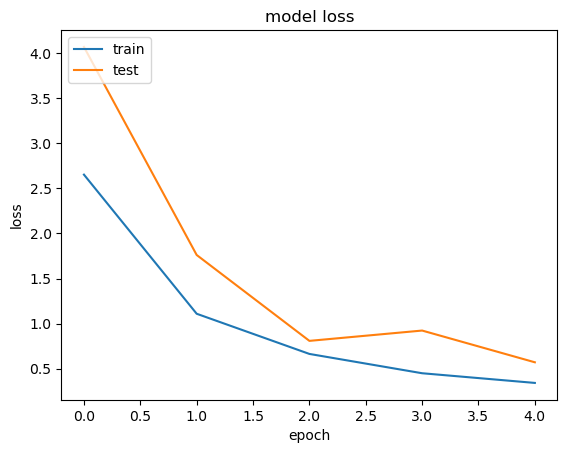

In [57]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Disease Prediction

1/1 [==============================] - 3s 3s/step
[0.00309214 0.00814862 0.0020823  0.00517271 0.00323273 0.02983707
 0.21051662 0.5045737  0.12795818 0.00460706 0.03559064 0.00369449
 0.04435075 0.00115926 0.01598386]


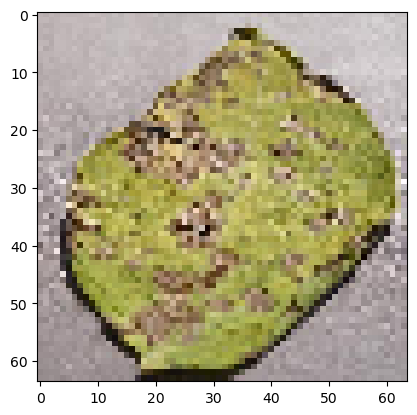

Prediction: Tomato_Late_blight


In [58]:
from skimage import io
# from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array


img = load_img('C:/Users/tushar swarnkar/Downloads/OIP.jpeg', grayscale=False, target_size=(1080, 1080))
# show_img = load_img('C:/Users/tushar swarnkar/Tushar anaconda/Project hackathon/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG', grayscale=False, target_size=(64,64))

disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = np.array(x, 'float32')
x /= 1080

custom = model.predict(x)
print(custom[0])



# x = x.reshape([64, 64]);

plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

- - 